In [232]:
import numpy as np
import librosa
import torch

from typing import Sequence, Union, Optional
from torch.utils.data import IterableDataset


class DatasetSineWave(IterableDataset):

    def __init__(
            self,
            num_samples_pred: int,
            frequencies: Sequence[int],
            batch_size: int,
            sample_rate: int = 200,
            duration: int = 5,
            n_fft: Optional[int] = None,
            hop_length: Optional[int] = None,
            windowed: bool = True,
            seed = None
    ):

        super(DatasetSineWave).__init__()
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        self.batch_size = batch_size
        self.sample_rate = sample_rate
        self.duration = duration
        if not isinstance(frequencies, (list, set, tuple)):
            frequencies = [frequencies]
        self.frequencies = sorted(frequencies)
        use_tf_domain: bool = bool(n_fft and hop_length)
        self.n_fft = n_fft if use_tf_domain else None
        self.hop_length = hop_length if use_tf_domain else None
        self.num_samples_pred = num_samples_pred
        self.windowed = windowed

    def __repr__(self):
        fmt_str = self.__class__.__name__ + '('
        fmt_str += f'batch_size={self.batch_size:0d}, '
        fmt_str += f'sample_rate={self.sample_rate:0d}, '
        fmt_str += f'duration={self.duration:0d}, '
        if self.n_fft is not None:
            fmt_str += f'n_fft={self.n_fft:0d}, '
        if self.hop_length is not None:
            fmt_str += f'hop_length={self.hop_length:0d}, '
        fmt_str += f'num_samples_pred={self.num_samples_pred:0d}, '
        if self.seed is not None:
            fmt_str += f'seed={self.seed}, '
        fmt_str += f'frequencies={self.frequencies}'
        fmt_str += ')'
        return fmt_str

    def __iter__(self):
        
        use_tf_domain: bool = bool(self.n_fft and self.hop_length)

        while True:

            # prepare time variable
            sr = self.sample_rate
            t = np.arange(0, int(self.duration * sr)) / sr

            x_batch, X_batch = [], []
            m_batch, M_batch = [], []

            for _ in range(self.batch_size):

                # prepare masking variable that selects one
                # of the sources at each second
                m = self.rng.choice(
                    range(len(self.frequencies)),
                    size=self.duration)
                M = None
                if use_tf_domain:
                    M = np.repeat(m, sr/self.hop_length)
                m = np.repeat(m, sr)

                # construct mixture
                x = []
                for f in self.frequencies:
                    a = self.rng.random()
                    p = 0 # ignore phase shifts
                    s = a * np.cos(2*np.pi*f*t)
                    x.append(s)

                # apply mask
                x = np.choose(m, x)

                # normalize the signal to have a max amplitude of 1
                x = x / np.max(x)
                
                # multiply hann window for transitions
                if self.windowed:
                    transition_points = np.abs(np.diff(m, append=1))
                    transition_scaling = 1 - np.convolve(
                        np.hanning(self.sample_rate//4),
                        transition_points, 'same')
                    x *= transition_scaling

                # compute magnitude STFT
                X = None
                if use_tf_domain:
                    X = np.abs(librosa.stft(
                        x, n_fft=self.n_fft,
                        hop_length=self.hop_length, center=False))
                
                if use_tf_domain:
                    X_batch.append(np.transpose(X))                    
                    M_batch.append(M)
                else:
                    x_batch.append(x)
                    m_batch.append(m)

            if use_tf_domain:
                X_batch = torch.FloatTensor(np.array(X_batch))
                M_batch = torch.FloatTensor(np.array(M_batch))
                
                if torch.cuda.is_available():
                    X_batch = X_batch.cuda()
                    M_batch = M_batch.cuda()

                yield (
                    X_batch[:, :-self.num_samples_pred],
                    X_batch[:, self.num_samples_pred:],
                    M_batch
                )
            else:
                x_batch = torch.FloatTensor(np.array(x_batch))
                m_batch = torch.FloatTensor(np.array(m_batch))

                if torch.cuda.is_available():
                    x_batch = x_batch.cuda()
                    m_batch = m_batch.cuda()
                
                yield (
                    x_batch[:, :-self.num_samples_pred],
                    x_batch[:, self.num_samples_pred:],
                    m_batch
                )

DatasetSineWave(batch_size=4, sample_rate=20, duration=5, num_samples_pred=1, seed=1, frequencies=[5, 10])
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

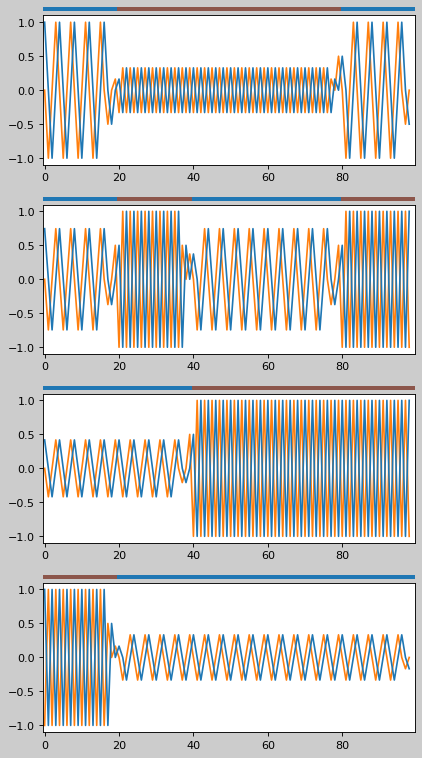

In [251]:
batch_size = 4
num_samples_pred = 1
frequencies = [5, 10]
torch.cuda.is_available = lambda : False
to_numpy = lambda v: v.detach().cpu().numpy()

dataset = DatasetSineWave(num_samples_pred, frequencies, batch_size, sample_rate=20, seed=1)
print(dataset)
x, y, m = next(iter(dataset))

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(nrows=batch_size, ncols=1, figsize=(6, batch_size*3), dpi=80, facecolor='#ccc')
for i in range(batch_size):
    ax[i].plot(to_numpy(x[i]))
    ax[i].plot(to_numpy(y[i]), zorder=-1)
    divider = make_axes_locatable(ax[i])
    block_ax = divider.append_axes("top", size=0.05, pad=0.05, sharex=ax[i])
    block_ax.imshow(to_numpy(m[i]).reshape(1,-1),
                    aspect='auto', cmap='tab10', interpolation='none',
                    vmin=0, vmax=len(frequencies))
    block_ax.set_axis_off()
plt.show()

In [88]:
m[0,1:]-m[0,:-1]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  